# Atividade 3: Classificação de Lixo Doméstico

> Classificação de lixo doméstico utilizando Python e Keras.

## Desafio

Classificar alguns objetos encontrados em lixo doméstico usando o _dataset_ do Kaggle disponível em https://www.kaggle.com/datasets/farzadnekouei/trash-type-image-dataset/.
O conjunto de dados possui 6 classes (6 tipos de lixo):

- 📦 Caixas de papelão;
- 🥂 Vidro;
- 🛢️ Metal;
- 🗞️ Papel;
- 🥤 Plástico;
- 🗑️ Entulhos (restos de embalagem, comida e outros que não se enquadram nas categorias anteriores).

## Autores

- Orientadora: Elloá B. Guedes - [@elloa](https://github.com/elloa)
- Time:
  - Debora Souza Barros - [@Debby-Barros](https://github.com/Debby-Barros)
  - Diana Martins - [@ddianaom](https://github.com/ddianaom)
  - Gabriel Dos Santos Lima - [@gabrielSantosLima](https://github.com/gabrielSantosLima)
  - Thiago Marques - [@tmmarquess ](https://github.com/tmmarquess)


## Etapa 0: Configuração do ambiente

Os tópicos que serão abordados nesta etapa:
* Importação das bibliotecas
* Baixar o _dataset_ para o arquivo local do projeto  

In [ ]:
! pip install optuna keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.3 MB/s eta 0:00:00


In [ ]:
import os
import zipfile
from glob import glob
import cv2
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [ ]:
# baixando do kaggle
if not os.path.isdir('dataset'):
  !rm -r sample_data
  !kaggle datasets download -d farzadnekouei/trash-type-image-dataset
  !unzip trash-type-image-dataset.zip
  !rm trash-type-image-dataset.zip
  !mv TrashType_Image_Dataset dataset
else:
  print("Conjunto de dados já existe no diretório atual.")

Conjunto de dados já existe no diretório atual.


## Etapa 1: Importação do conjunto de dados

Os tópicos que serão abordados nesta etapa:
* Importar o _dataset_
* Verificar quantos exemplos o _dataset_ possui

In [ ]:
# diretório do dataset
base_dir = 'dataset'

# quantidade de exemplos do dataset
image_files = glob(os.path.join(base_dir, '**', '*.jpg'), recursive=True)
print(f'O dataset possui {len(image_files)} imagens')

O dataset possui 2527 imagens


## Etapa 2: Análise exploratória

Os tópicos que podem ser abordados nesta etapa:
* Buscar explorar informações relevantes sobre a base de dados. Algumas sugestões de perguntas que podem servir como ponto de partida:
  * Quantas classes existem?
  * Quantos exemplos cada classe possui?
* Analisar a qualidade das imagens do _dataset_ e descrever as limitações que podem ser encontradas (se possível apresentar exemplos)

In [ ]:
# quantidade de classes no dataset
count_classes = 0
for dir in os.listdir(base_dir):
  count_classes += 1

print(f"No dataset 'Trash type' existem {count_classes} classes")

No dataset 'Trash type' existem 6 classes


In [ ]:
# quantidades de exemplos em cada classe
files_count = {}
for root, dirs, files in os.walk(base_dir):
  for dir in dirs:
    qtd_files = os.path.join(root, dir)
    count = len(os.listdir(qtd_files))
    files_count[dir] = count


for key, item in files_count.items():
  print(f'Na classe "{key}" existem {item} imagens')

Na classe "metal" existem 410 imagens
Na classe "paper" existem 594 imagens
Na classe "glass" existem 501 imagens
Na classe "trash" existem 137 imagens
Na classe "cardboard" existem 403 imagens
Na classe "plastic" existem 482 imagens


In [ ]:
# Dimensões das imagens
def img_dimensions(img_dir):
    files = os.listdir(img_dir)
    dim = []
    for file in files:
        img_path = os.path.join(img_dir, file)
        img = cv2.imread(img_path)

        height, width, channels = img.shape
        dim.append((height, width))

    count_dim = Counter(dim)

    print("Dimensões mais comuns:")
    for dim, freq in count_dim.most_common(15):
        print(f"Dimensão (altura x largura): {dim}, Frequência: {freq}")
    print('\n')


for dir in os.listdir(base_dir):
  dir_path = os.path.join(base_dir, dir)
  if os.path.isdir(dir_path):
    print(f'Analisando imagens em: {dir_path}')
    img_dimensions(dir_path)

Analisando imagens em: dataset/metal
Dimensões mais comuns:
Dimensão (altura x largura): (384, 512), Frequência: 410


Analisando imagens em: dataset/paper
Dimensões mais comuns:
Dimensão (altura x largura): (384, 512), Frequência: 594


Analisando imagens em: dataset/glass
Dimensões mais comuns:
Dimensão (altura x largura): (384, 512), Frequência: 501


Analisando imagens em: dataset/trash
Dimensões mais comuns:
Dimensão (altura x largura): (384, 512), Frequência: 137


Analisando imagens em: dataset/cardboard
Dimensões mais comuns:
Dimensão (altura x largura): (384, 512), Frequência: 403


Analisando imagens em: dataset/plastic
Dimensões mais comuns:
Dimensão (altura x largura): (384, 512), Frequência: 482




Imagens de: dataset/metal


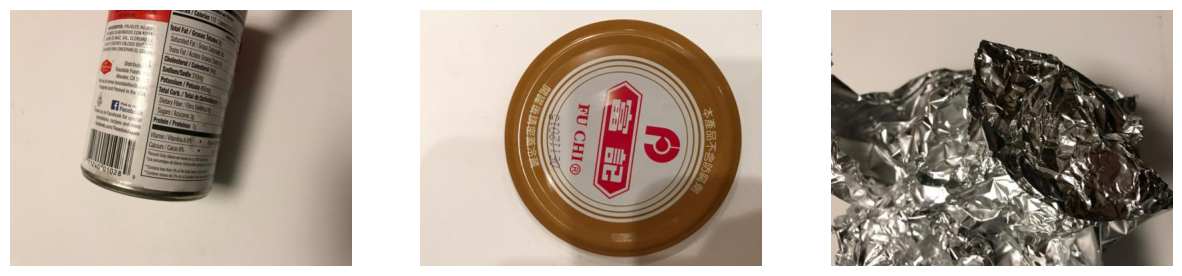

Imagens de: dataset/paper


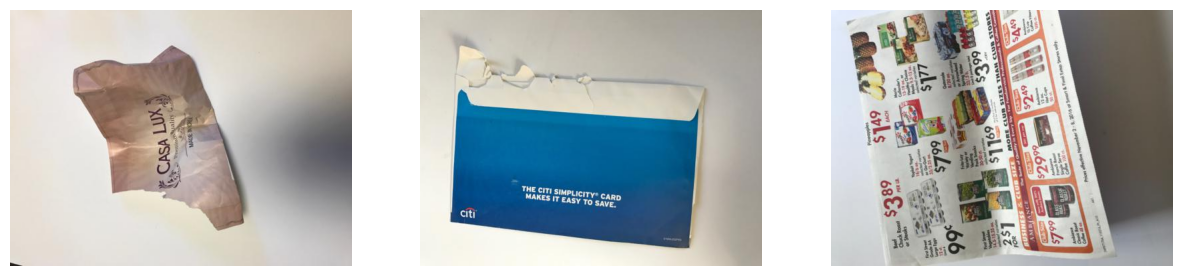

Imagens de: dataset/glass


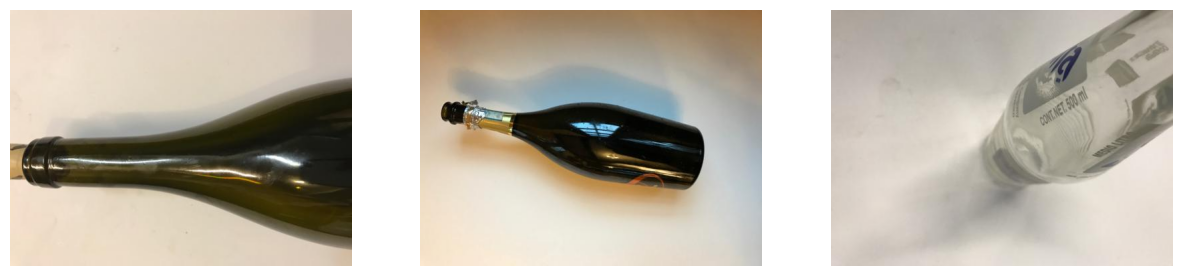

Imagens de: dataset/trash


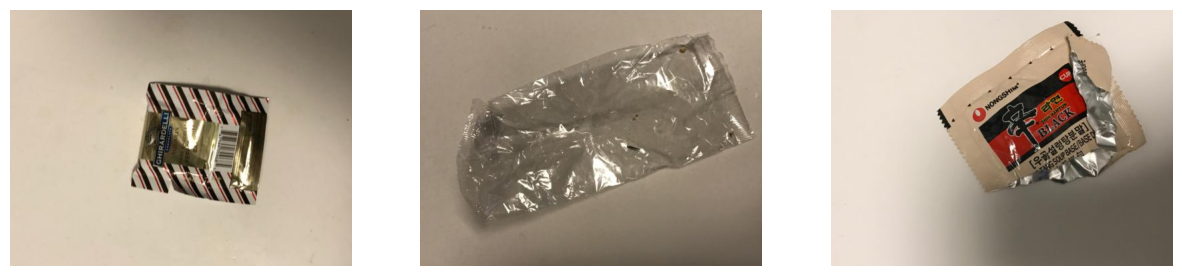

Imagens de: dataset/cardboard


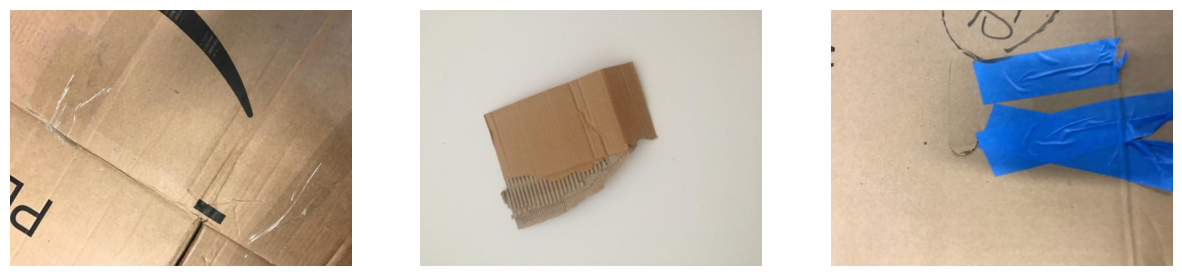

Imagens de: dataset/plastic


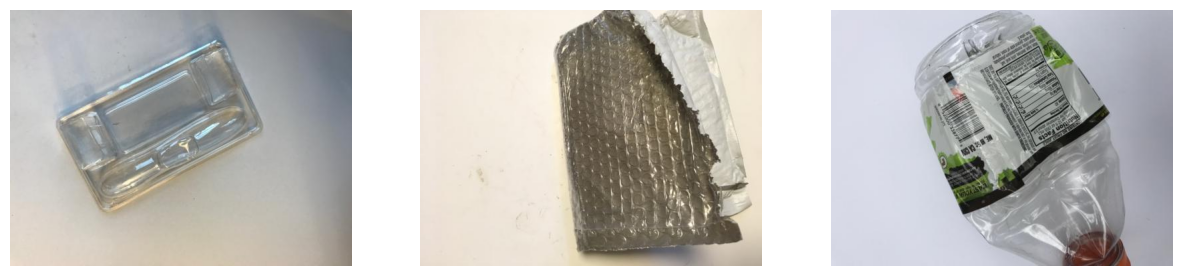

In [ ]:
# plotando algumas imagens das classes do dataset 'Trash Type'
def plot_images_from_subfolders(base_dir, num_images=3):
    subfolders = [os.path.join(base_dir, folder) for folder in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, folder))]

    for folder_path in subfolders:
        print(f"Imagens de: {folder_path}")
        fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(15, 5))
        files = os.listdir(folder_path)

        for i in range(num_images):
            img_path = os.path.join(folder_path, files[i])
            img = cv2.imread(img_path)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[i].imshow(img_rgb)
            axes[i].axis('off')
        plt.show()

plot_images_from_subfolders(base_dir, 3)

## Etapa 3: Pré-processamento

Os tópicos que podem ser abordados nesta etapa:
* Definir o tamanho da grade de busca a ser contemplada
* Preparar o conjunto de dados para o treinamento com a estratégia de validação cruzada _holdout_

In [ ]:
# tamanho da grade de busca a ser contemplada

# MLP do SkLearn
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'batch_size': [32, 64, 128]
}

In [ ]:
# Utilizano Keras
# Com o Keras é possível utilizar a classe GridSearchCV do SkLearn
param_grid_keras = {
    'units': [32, 64, 128, 256],
    'activation': ['relu', 'tanh', 'sigmoid'],
    'optimizer': ['adam', 'sgd', 'rmsprop'],
    'learning_rate': [0.001, 0.01, 0.1],
    'batch_size': [32, 64, 128],
    'epochs': [10, 20, 30]
}

In [ ]:
# Pytorch com Optuna
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

param_grid_pytorch = {
    'n_units': [32, 64, 128, 256],
    'activation': ['relu', 'tanh', 'sigmoid'],
    'optimizer': ['adam', 'sgd', 'rmsprop'],
    'learning_rate': [0.001, 0.01, 0.1],
    'batch_size': [32, 64, 128],
    'epochs': [10, 20, 30]
}

def objective(trial):
    n_units = trial.suggest_categorical('n_units', [32, 64, 128, 256])
    activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid'])
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'sgd', 'rmsprop'])
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    epochs = trial.suggest_categorical('epochs', [10, 20, 30])
    # model = Net(n_units, activation).to(device)
    # optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=learning_rate)
    # criterion = nn.CrossEntropyLoss()

    # train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)

    # for epoch in range(epochs):
    #     model.train()
    #     for data, target in train_loader:
    #         optimizer.zero_grad()
    #         output = model(data)
    #         loss = criterion(output, target)
    #         loss.backward()
    #         optimizer.step()

    # val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)
    # model.eval()
    # correct = 0
    # with torch.no_grad():
    #     for data, target in val_loader:
    #         output = model(data)
    #         pred = output.argmax(dim=1, keepdim=True)
    #         correct += pred.eq(target.view_as(pred)).sum().item()

    # accuracy = correct / len(val_loader.dataset)
    # return accuracy

#study = optuna.create_study(direction='maximize')
#study.optimize(objective, n_trials=100)

In [ ]:
# TensorFlow
import tensorflow as tf
from tensorflow import keras
from keras_tuner import HyperModel, RandomSearch

param_grid_tensorflow = {
    'units': [32, 64, 128, 256],
    'activation': ['relu', 'tanh', 'sigmoid'],
    'optimizer': ['adam', 'sgd', 'rmsprop'],
    'learning_rate': [0.001, 0.01, 0.1],
    'batch_size': [32, 64, 128],
    'epochs': [10, 20, 30]
}

class MyHyperModel(HyperModel):
    def build(self, hp):
        model = keras.Sequential()
        model.add(keras.layers.Dense(units=hp.Choice('units', [32, 64, 128, 256]), activation=hp.Choice('activation', ['relu', 'tanh', 'sigmoid'])))
        model.add(keras.layers.Dense(10, activation='softmax'))
        model.compile(optimizer=hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop']),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
        return model

# tuner = RandomSearch(
#     MyHyperModel(),
#     objective='val_accuracy',
#     max_trials=10,
#     executions_per_trial=3,
#     directory='my_dir',
#     project_name='helloworld'
# )

# tuner.search(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

In [ ]:
# Preparar o conjunto de dados para o treinamento com a estratégia de validação cruzada holdout
files_dict = []
for root, dirs, files in os.walk(base_dir):
  for dir in dirs:
    for file in os.listdir(os.path.join(root, dir)):
      img_path = os.path.join(root, dir, file)
      img = cv2.imread(img_path)
      height, width, _ = img.shape
      files_dict.append(dict(filename=file, path=os.path.join(root, dir, file), _class=dir, dimensions=(height, width)))

df = pd.DataFrame(files_dict)

In [ ]:
df.head()

,filename,path,_class,dimensions
0,metal_098.jpg,dataset/metal/metal_098.jpg,metal,"(384, 512)"
1,metal_065.jpg,dataset/metal/metal_065.jpg,metal,"(384, 512)"
2,metal_114.jpg,dataset/metal/metal_114.jpg,metal,"(384, 512)"
3,metal_019.jpg,dataset/metal/metal_019.jpg,metal,"(384, 512)"
4,metal_359.jpg,dataset/metal/metal_359.jpg,metal,"(384, 512)"


In [ ]:
df["_class"].value_counts()

_class
paper        594
glass        501
plastic      482
metal        410
cardboard    403
trash        137
Name: count, dtype: int64

In [ ]:
def train_test_split(x, y, test_size=0.7, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)

    shuffled_indices = np.random.permutation(len(x))

    test_set_size = int(len(x) * test_size)

    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]

    x_train = x.iloc[train_indices]
    x_test = x.iloc[test_indices]
    y_train = y.iloc[train_indices]
    y_test = y.iloc[test_indices]



    return x_train, x_test, y_train, y_test

In [ ]:
X = df.drop(columns=["_class"])
y = df["_class"]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=.7)

## Etapa 4: Treinamento e testes dos modelos

Os tópicos que serão abordados nesta etapa:
* Definir qual o modelo que será utilizado e quais arquiteturas serão avaliadas
* Preparar modelo(s) para grade de busca
* Treinamento
* Teste do(s) modelo(s)

## Etapa 5: Análise quantitativa e qualitativa de desempenho dos modelos avaliados

Os tópicos que podem ser abordados nesta etapa:
* Análise quantitativa do(s) modelo(s)
* Análise qualitativa do(s) modelo(s)
* Conclusão. Incluir na dissertação:
  * Sugestões de melhoria;
  * Desafios;
  * Próximos passos.